The K-means clustering algorithm operates based on proximity, seeking to group the points closest to each other to form clusters. In contrast, Gaussian Mixture Models (GMMs) assume the existence of several Gaussian distributions, each of which represents a distinct cluster. GMMs have a tendency to group data points together that belong to the same distribution. In this exercise, the task involves varying the number of Gaussian distributions used to estimate densities and comparing the results in order to determine the optimal number of distributions to be employed.

To perform this task, first import the libraries necessary to solve this problem


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from sklearn.cluster import KMeans
import math
import random as rd
from numpy import pi
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

After this, the functions that will be used are defined, in this case mykmedias, pdfnvar and mymix, in addition to the spiral function that was developed in order to compensate for the absence of the mlbench package in Python


In [ ]:
def mykmedias(X, k, max_iterations=100):
  N, n = X.shape
  mi = np.random.choice(N, k, replace=False)
  m = X[mi]

  for _ in range(max_iterations):
      c = np.argmin(distance.cdist(X, m), axis=1)
      new_m = np.array([X[c == i].mean(axis=0) for i in range(k)])
      if np.all(m == new_m):
          break
      m = new_m

  return m, c

def pdfnvar(x, m, K):
  n = np.array(x).shape[0]
  det_K = np.linalg.det(K)
  return (1 / (np.sqrt((2 * np.pi) ** n * det_K)) * np.exp(-0.5 * np.dot(x - m, np.linalg.solve(K, x - m))))

def mymix(x, inlist):
  num_clusters = len(inlist)
  k_list = [np.cov(cluster.T) for cluster in inlist]
  m_list = [np.mean(cluster, axis=0) for cluster in inlist]
  num_dimensoes = [np.array(cluster).shape[0] for cluster in inlist]

  N = sum(num_dimensoes)
  pglist = [num / N for num in num_dimensoes]

  Px = sum(pg * pdfnvar(x, m, K) for pg, m, K in zip(pglist, m_list, k_list))
  return Px

def spiral(N=250):
  theta = np.sqrt(np.random.rand(N))*2*pi

  r_a = 2*theta + pi
  data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  x_a = (data_a + np.random.randn(N,2))/10

  r_b = -2*theta - pi
  data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  x_b = (data_b + np.random.randn(N,2))/10

  res_a = np.append(x_a, np.zeros((N,1)), axis=1)
  res_b = np.append(x_b, np.ones((N,1)), axis=1)

  res = np.append(res_a, res_b, axis=0)
  np.random.shuffle(res)

  return x_a, x_b


Below you can see the output of the spiral function


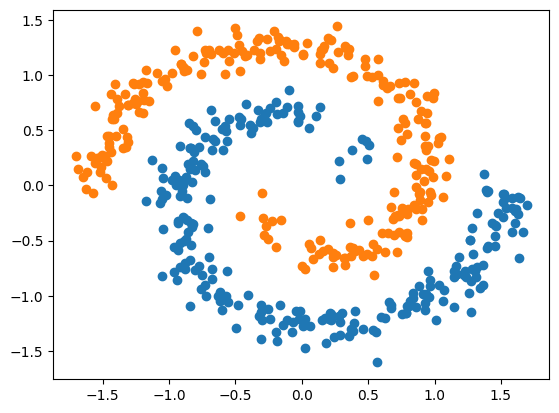

In [ ]:
a, b = spiral()

plt.scatter(a[:,0],a[:,1])
plt.scatter(b[:,0],b[:,1])
plt.show()

Once the data is generated, we create a variable xall that will represent all the information of x and yall that represents the response of the information (if the sample is from class 1 or class 2)


In [ ]:
xall = np.concatenate((a,b))
yall = np.concatenate((np.zeros(250)+1,np.ones(250)+1))

In [ ]:
xc1 = a
xc2 = b

Below is the sample plot, with class 1 in blue and class 2 in red.


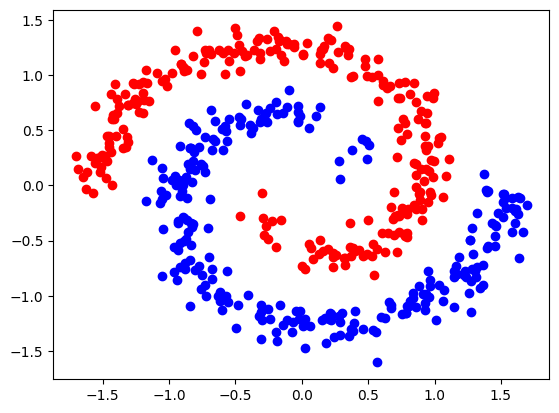

In [ ]:
N=500
percent_train = 0.9
k = 30
acuracias = np.zeros(10)

num_k_folders = 10
tam_fold = N // num_k_folders

plt.scatter(xc1[:, 0], xc1[:, 1], c='blue')
plt.scatter(xc2[:, 0], xc2[:, 1], c='red')

In [ ]:
print(tam_fold)

50


A detail that could be the cause of a problem in the future is that the samples are sequential, that is, the first half represents class 1 and the second class 2, so to ensure that training and testing are done correctly , we will shuffle these samples into a variable called data (which will receive xall and yall)


In [ ]:
data = np.column_stack((xall, yall))
np.random.shuffle(data)

df = pd.DataFrame(data)
N = 20
print(df.head(N))

           0         1    2
0  -1.230022  0.764680  2.0
1   0.656671 -1.059847  1.0
2  -0.838968 -0.672968  1.0
3  -0.807376  0.136676  1.0
4   0.996831  0.222201  2.0
5   0.325921 -0.718341  2.0
6  -0.979660  0.050473  1.0
7  -0.920455 -0.739115  1.0
8   0.460625 -0.641646  2.0
9   0.570555  0.766598  2.0
10 -0.787401  1.403636  2.0
11 -1.532165  0.251434  2.0
12  0.857387  0.198271  2.0
13  0.967016 -0.911331  1.0
14  0.103762  0.626041  1.0
15 -0.847611  0.569972  1.0
16  1.283207 -0.761370  1.0
17  0.797582 -0.210419  2.0
18  0.264513  1.442234  2.0
19  0.564097 -0.571919  2.0


In [ ]:
data.shape

(500, 3)

Finally, we implement the code responsible for training using the previously defined functions and the k-fold method with k=10, this means that we will separate 10% of the samples for testing and 90% for training, but we will alternate the set 10 times so that the 10% samples selected for testing will be covered in the data variable, thus taking all samples once for testing and the other 90% for training


In [ ]:
fold = []
acuracias_mean = []
result = []
for k in range(2,11):
  kf = KFold(n_splits=k, shuffle=True, random_state=42)
  acuracias = []
  for fold in range(1,num_k_folders+1):
    aux = fold-1
    start_idx = int(aux * data.shape[0] / num_k_folders)
    end_idx = int((aux + 1) * data.shape[0] / num_k_folders)
    test_indices = list(range(start_idx, end_idx))
    train_indices = list(set(range(data.shape[0])) - set(test_indices))

    x_train = data[train_indices, :-1]
    y_train = data[train_indices, -1]

    x_test = data[test_indices, :-1]
    y_test = data[test_indices, -1]

    retlist = mykmedias(x_train, k)

    xclusters = []

    for i in range(1, k + 1):
      ici = np.where(np.array(retlist[1]) == i)[0]
      xclusters.append(x_train[ici, :])

    seqi = np.arange(-1.5, 1.55, 0.05)
    seqj = np.arange(-1.5, 1.55, 0.05)

    M = np.ones((len(seqi), len(seqj)))
    ci = 0

    for i in seqi:
        ci += 1
        cj = 0
        for j in seqj:
            cj += 1
            x = [i, aux]
            M[ci - 1, cj - 1] = mymix(x, xclusters)



    Yhat = []
    for i in range(tam_fold):
      if(mymix(x_train[i], xclusters) >= 1):
        Yhat.append(2)
      else:
        Yhat.append(1)

    soma_erros = np.sum(np.abs(Yhat - y_test))

    acuracia = soma_erros / tam_fold

    acuracias.append(acuracia)

    print(f'Acurácia para o fold {fold}: {acuracia}')
  print(f'\nCaso K = {k}:')
  print(f'Acuracias K={k}: {acuracias}')
  print(f'Media = {np.array(acuracias).mean()}\n\n')
  acuracias_mean.append(np.array(acuracias).mean())


<ipython-input-18-c3ca39523a6d>:22: RuntimeWarning: Degrees of freedom <= 0 for slice
  k_list = [np.cov(cluster.T) for cluster in inlist]


Acurácia para o fold 1: 0.54
Acurácia para o fold 2: 0.42
Acurácia para o fold 3: 0.52
Acurácia para o fold 4: 0.6
Acurácia para o fold 5: 0.52
Acurácia para o fold 6: 0.5
Acurácia para o fold 7: 0.48
Acurácia para o fold 8: 0.52
Acurácia para o fold 9: 0.48
Acurácia para o fold 10: 0.42

Caso K = 2:
Acuracias K=2: [0.54, 0.42, 0.52, 0.6, 0.52, 0.5, 0.48, 0.52, 0.48, 0.42]
Media = 0.5


Acurácia para o fold 1: 0.54
Acurácia para o fold 2: 0.42
Acurácia para o fold 3: 0.52
Acurácia para o fold 4: 0.6
Acurácia para o fold 5: 0.52
Acurácia para o fold 6: 0.5
Acurácia para o fold 7: 0.48
Acurácia para o fold 8: 0.52
Acurácia para o fold 9: 0.48
Acurácia para o fold 10: 0.42

Caso K = 3:
Acuracias K=3: [0.54, 0.42, 0.52, 0.6, 0.52, 0.5, 0.48, 0.52, 0.48, 0.42]
Media = 0.5


Acurácia para o fold 1: 0.54
Acurácia para o fold 2: 0.42
Acurácia para o fold 3: 0.52
Acurácia para o fold 4: 0.6
Acurácia para o fold 5: 0.52
Acurácia para o fold 6: 0.5
Acurácia para o fold 7: 0.48
Acurácia para o fol

In this study that involved the use of k-means for mixture analysis, a relatively low accuracy was observed. This can be attributed to the fact that the data was sparse and of poor quality. However, despite the less favorable results, the experiment provided a valuable opportunity to deepen the understanding of how the mixture classifier works with k-means and to implement it efficiently.
